# Predict mel-cepstrum parameters

In [1]:
import numpy as np
import h5py
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import SGD, Adadelta
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Model

In [2]:
hidden_layers = 6

In [3]:
nlayers=1024
model = Sequential()
model.add(Dense(nlayers, input_dim=215, activation='tanh', init = 'glorot_normal'))
model.add(Dropout(0.5))
for i in range(0,hidden_layers):
    model.add(Dense(nlayers, activation='tanh',init = 'glorot_normal'))
    model.add(Dropout(0.5))
model.add(Dense(6, activation='sigmoid'))

model.summary()        

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1024)          221184      dense_input_1[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1024)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1024)          1049600     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 1024)          0           dense_2[0][0]                    
___________________________________________________________________________________________

In [4]:
early_stopping = EarlyStopping(patience=16)

In [5]:
model.compile(optimizer=SGD(lr=0.1, momentum=0.6, nesterov=False), loss='mse', metrics=['accuracy'])

### Data import

In [6]:
data = []
with h5py.File('preprocessed_data/train-standardized.h5','r') as hf:
    data = np.array(hf.get('dataset'))
input_data = data[:,0:215]
print(input_data.shape)
target_data = data[:,216:222]
target_data = target_data
print(target_data.shape)

(280352, 215)
(280352, 6)


In [7]:
maxs = np.max(target_data, axis=0)
mins = np.min(target_data, axis=0)
target_data = (target_data-mins)/(maxs-mins)

In [8]:
target_data[0]

array([ 0.68308842,  0.77916102,  0.53995687,  0.30888697,  0.48745878,
        0.54952448])

Validation

In [9]:
data_validation = []
with h5py.File('preprocessed_data/validation.h5','r') as hf:
    data_validation = np.array(hf.get('dataset'))
input_validation = data_validation[:,0:215]
print(input_validation.shape)
target_validation = data_validation[:,216:222]
target_validation = target_validation
print(target_validation.shape)

(15789, 215)
(15789, 6)


In [10]:
mean = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    mean = np.array(hf.get('dataset'))
sdt = []
with h5py.File('preprocessed_data/train-mean.h5') as hf:
    std = np.array(hf.get('dataset'))

In [11]:
input_validation2 = (input_validation-mean[0:215])/(std[0:215])

In [12]:
target_validation = (target_validation-mins)/(maxs-mins)

## Train

In [13]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir='log_mc_n', histogram_freq=0, write_graph=True,
                                                   write_images=False)

In [33]:
model.fit(input_data, target_data, nb_epoch=1000, 
          validation_data=(input_validation2, target_validation),batch_size=1024, verbose=1,
         callbacks=[early_stopping, tensorboard_callback])

Train on 280352 samples, validate on 15789 samples
Epoch 1/1000
280352/280352 [==============================] - 9s - loss: 0.0178 - acc: 0.4548 - val_loss: 0.0248 - val_acc: 0.4762
Epoch 2/1000
280352/280352 [==============================] - 9s - loss: 0.0177 - acc: 0.4559 - val_loss: 0.0246 - val_acc: 0.4746
Epoch 3/1000
280352/280352 [==============================] - 9s - loss: 0.0176 - acc: 0.4582 - val_loss: 0.0248 - val_acc: 0.4743
Epoch 4/1000
280352/280352 [==============================] - 11s - loss: 0.0175 - acc: 0.4589 - val_loss: 0.0247 - val_acc: 0.4741
Epoch 5/1000
280352/280352 [==============================] - 9s - loss: 0.0175 - acc: 0.4596 - val_loss: 0.0246 - val_acc: 0.4779
Epoch 6/1000
280352/280352 [==============================] - 9s - loss: 0.0174 - acc: 0.4623 - val_loss: 0.0247 - val_acc: 0.4800
Epoch 7/1000
280352/280352 [==============================] - 9s - loss: 0.0174 - acc: 0.4611 - val_loss: 0.0243 - val_acc: 0.4824
Epoch 8/1000
280352/280352 [===

In [15]:
model.save('models_data/model_mc.h5')
model.save_weights('models_data/model_mc_weights.h5')

h5f = h5py.File('models_data/max_min_mc.h5', 'w')
h5f.create_dataset('dataset',data=[maxs,mins])
h5f.close()

## Evaulation

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
data_test = []
with h5py.File('preprocessed_data/test.h5','r') as hf:
    data_test = np.array(hf.get('dataset'))
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,216:222]
print(target_test.shape)

(18569, 215)
(18569, 6)


In [18]:
data_test = []
with h5py.File('preprocessed_data/test.h5','r') as hf:
    data_test = np.array(hf.get('dataset'))
    


    
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,216:222]
print(target_test.shape)

(18569, 215)
(18569, 6)


In [19]:
input_test2 = (input_test-mean[0:215])/(std[0:215])
target_test2 = (target_test-mins)/(maxs-mins)

In [20]:
evaulate_data = model.evaluate(input_test2, target_test2, batch_size=32, verbose=1, sample_weight=None)

18560/18569 [============================>.] - ETA: 0s

In [21]:
evaulate_data

[0.024199371371530384, 0.46195271689856249]

In [22]:
output_test = []
for test in input_test2:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test).reshape(6))
output_test= np.asarray(output_test)

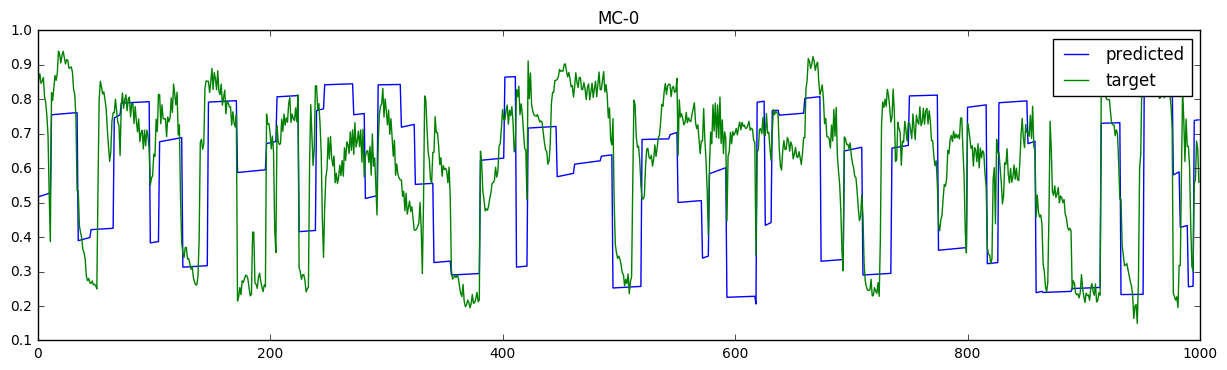

In [23]:
plt.figure(figsize=(15,4))
n=0
plt.title('MC-{}'.format(n))
plt.plot(output_test[0:1000,n],label='predicted')
plt.plot(target_test2[0:1000,n],label='target')
plt.legend()
plt.show()

### Single sentence test

In [24]:
import generate_dataset as gt
data_test = gt.generate_sentence_data(["arctic_a0348","Get down and dig in."])
data_test = np.array(data_test)

arctic_a0348
176


In [25]:
input_test = data_test[:,0:215]
print(input_test.shape)
target_test = data_test[:,216:222]
print(target_test.shape)

input_test2 = (input_test-mean[0:215])/(std[0:215])
target_test2 = (target_test-mins)/(maxs-mins)

(176, 215)
(176, 6)


In [26]:
output_test = []
for test in input_test2:
    test = np.array(test)
    test = test.reshape(1,215)
    output_test.append(model.predict(test).reshape(6))
output_test= np.asarray(output_test)

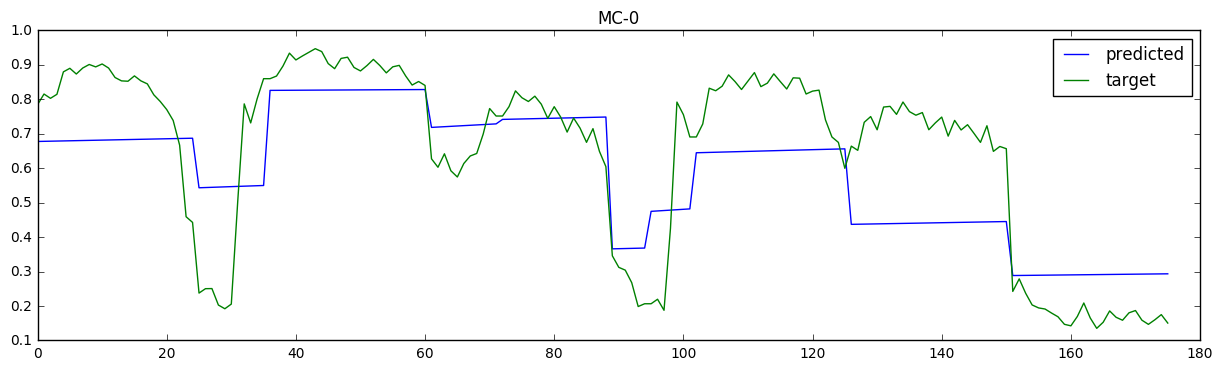

In [27]:
plt.figure(figsize=(15,4))
n=0
plt.title('MC-{}'.format(n))
plt.plot(output_test[0:1000,n],label='predicted')
plt.plot(target_test2[0:1000,n],label='target')
plt.legend()
plt.show()

In [28]:
test_mc = np.array(output_test*(maxs-mins)+mins)#.reshape(len(output_test))
test_mc.shape

(176, 6)

In [29]:
# audio file rate
rate = 16000

# frame data for pitch and mel-cepstrum
window_size = 256
window_step = 80

In [30]:
# order and alpha of mel-cepstrum
order = 5
alpha = 0.41

import pysptk
import librosa
from IPython.display import Audio



from pysptk.synthesis import MLSADF, Synthesizer

#source_excitation = pysptk.excite(test_f0s, 80)
source_excitation = pysptk.excite(data_test[:,215].copy(order='C'), 80)
# Convert mel-cesptrum to MLSADF coefficients
a = np.apply_along_axis(pysptk.mc2b, 1, data_test[:,216:222], alpha);
b = np.apply_along_axis(pysptk.mc2b, 1, test_mc, alpha);

synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), window_step)

mc_synthesized = synthesizer.synthesis(source_excitation, a)
mc_synthesized_pred =synthesizer.synthesis(source_excitation, b)

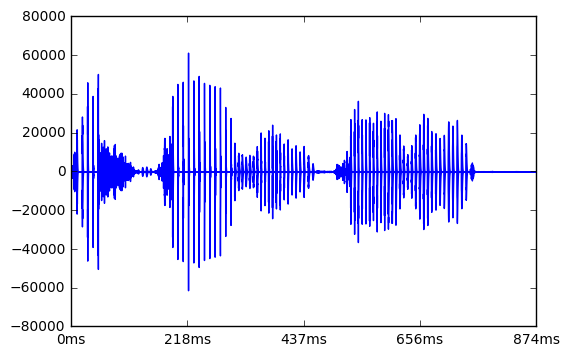

In [31]:
librosa.display.waveplot(mc_synthesized, sr=16000)
Audio(mc_synthesized, rate=16000)

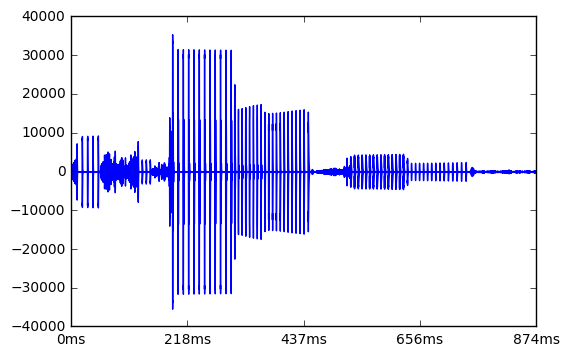

In [32]:
librosa.display.waveplot(mc_synthesized_pred, sr=16000)
Audio(mc_synthesized_pred, rate=16000)